<a href="https://colab.research.google.com/github/kritisinghh/Weather-Based-Power-Load-Forecasting/blob/main/Weather_Based_Power_Load_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
df = pd.read_csv('/PJME_hourly.csv', index_col=[0], parse_dates=[0])

df.sort_index(inplace=True)

print("Dataset Info:")
df.info()

print("\nFirst 10 rows:")
display(df.head(10))

print("\nSummary Statistics:")
display(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB

First 10 rows:


,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
2002-01-01 06:00:00,28654.0
2002-01-01 07:00:00,29308.0
2002-01-01 08:00:00,29595.0
2002-01-01 09:00:00,29943.0



Summary Statistics:


,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [ ]:
print(f"Missing values before handling: {df.isnull().sum().sum()}")

if df.isnull().sum().sum() > 0:
    df = df.interpolate(method='time')
    print(f"Missing values after interpolation: {df.isnull().sum().sum()}")

if df.index.duplicated().any():
    print("Duplicate timestamps found. Resampling by taking the mean.")
    df = df.resample('H').mean()

df.columns = ['EnergyLoad_MWh']

q99 = df['EnergyLoad_MWh'].quantile(0.99)
df = df[df['EnergyLoad_MWh'] < q99]

Missing values before handling: 0
Duplicate timestamps found. Resampling by taking the mean.


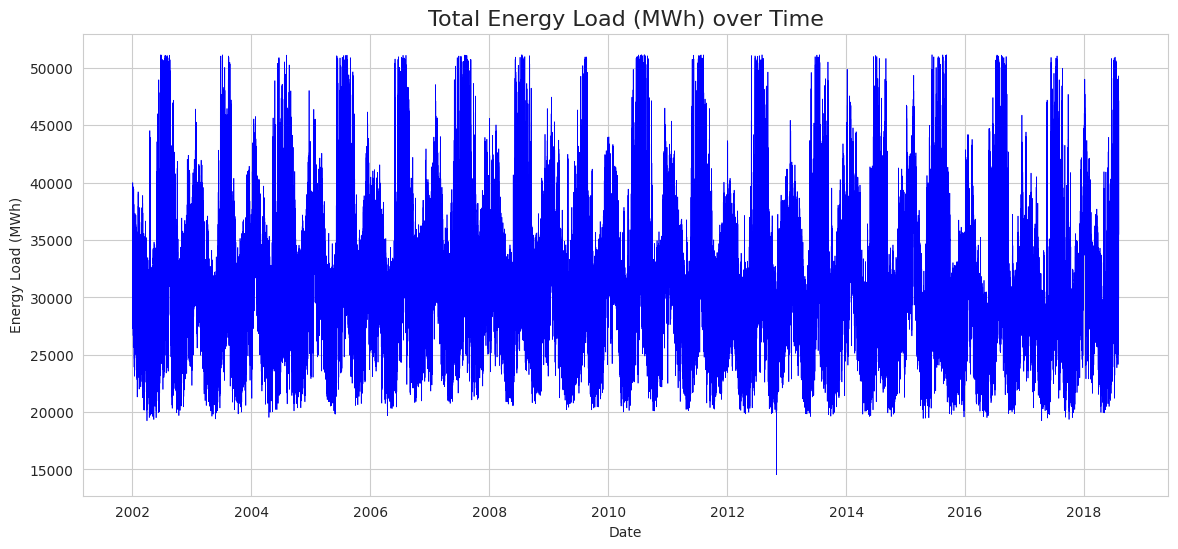

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['EnergyLoad_MWh'], linewidth=0.5, color='blue')
plt.title('Total Energy Load (MWh) over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Energy Load (MWh)')
plt.show()

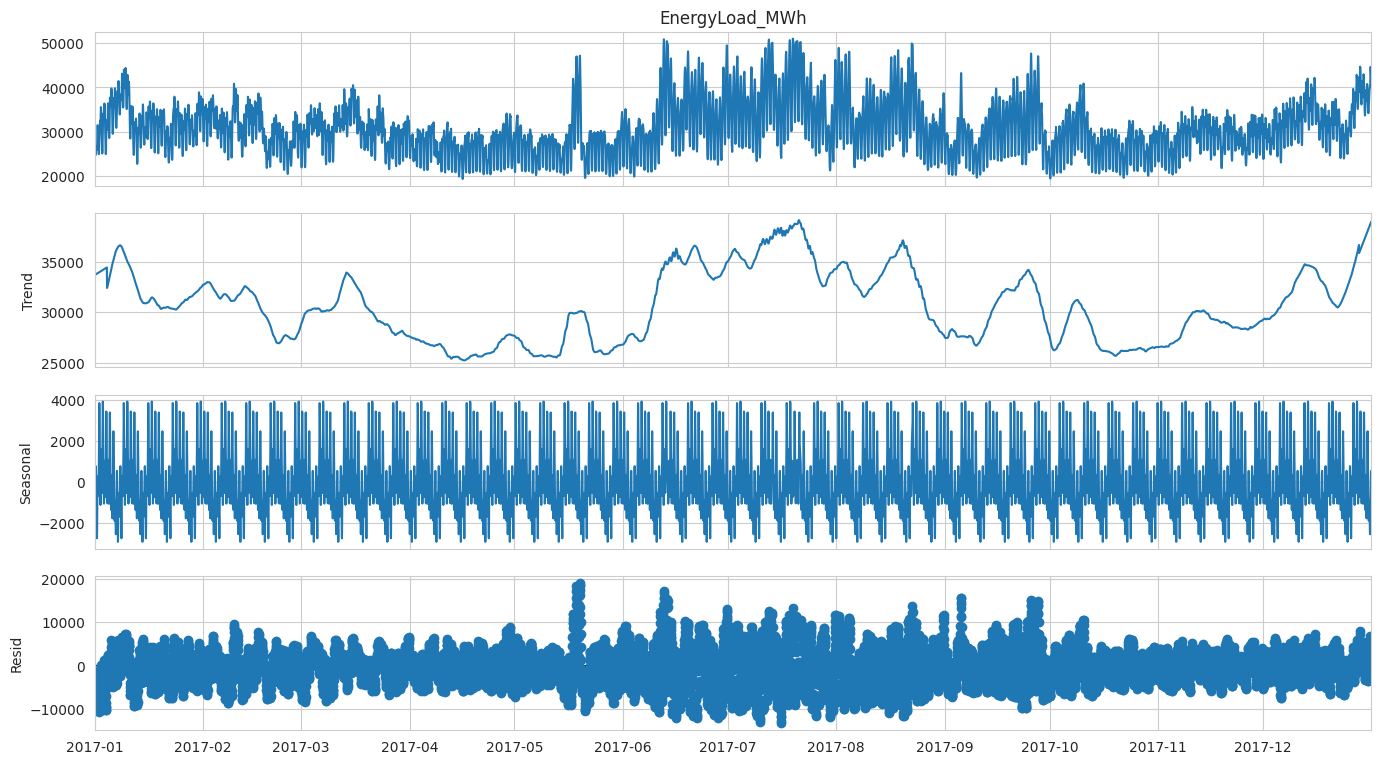

In [ ]:
decomposition = seasonal_decompose(df['EnergyLoad_MWh'].loc['2017-01-01':'2017-12-31'], period=168, extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()

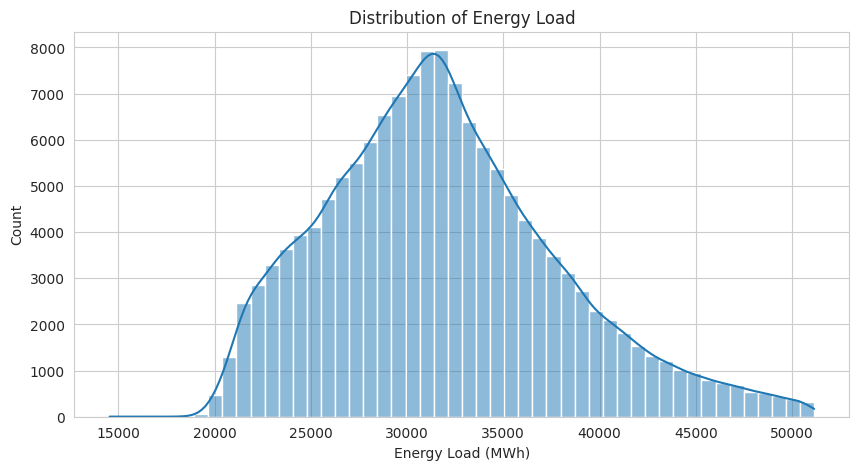

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['EnergyLoad_MWh'], kde=True, bins=50)
plt.title('Distribution of Energy Load')
plt.xlabel('Energy Load (MWh)')
plt.show()

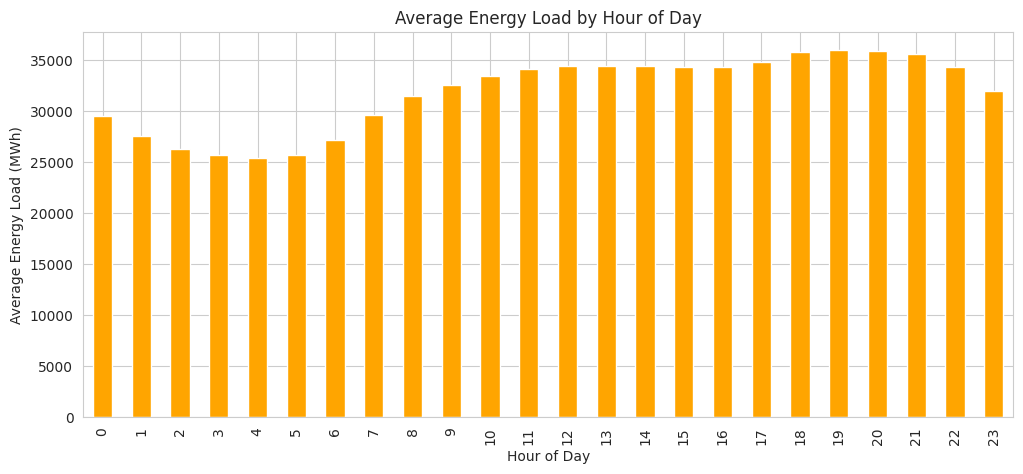

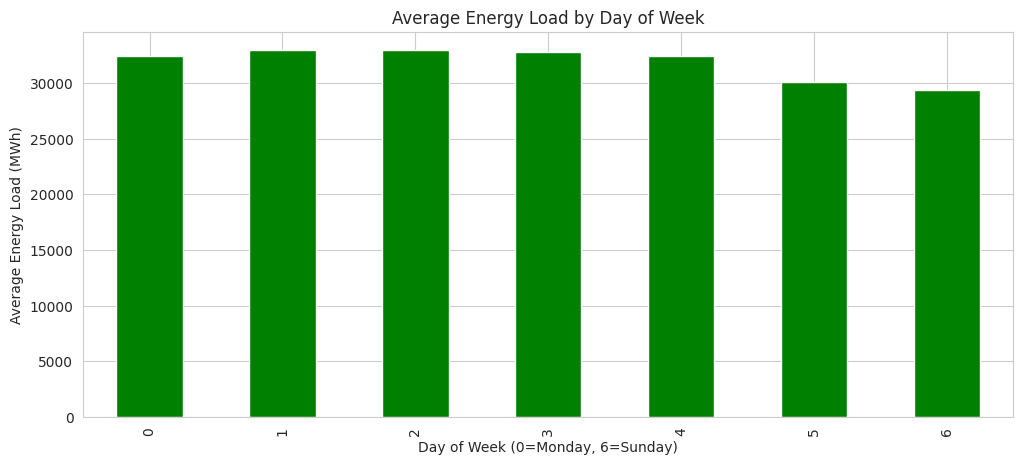

In [ ]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek

plt.figure(figsize=(12, 5))
df.groupby('hour')['EnergyLoad_MWh'].mean().plot(kind='bar', color='orange')
plt.title('Average Energy Load by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Load (MWh)')
plt.show()

plt.figure(figsize=(12, 5))
df.groupby('day_of_week')['EnergyLoad_MWh'].mean().plot(kind='bar', color='green')
plt.title('Average Energy Load by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Energy Load (MWh)')
plt.show()


In [ ]:
bright_palette = ['#FF6B6B', '#4ECDC4', '#FFE66D', '#6A0572', '#FF9A8B', '#83E8BA', '#FF85A1', '#9370DB']
sns.set_palette(bright_palette)
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

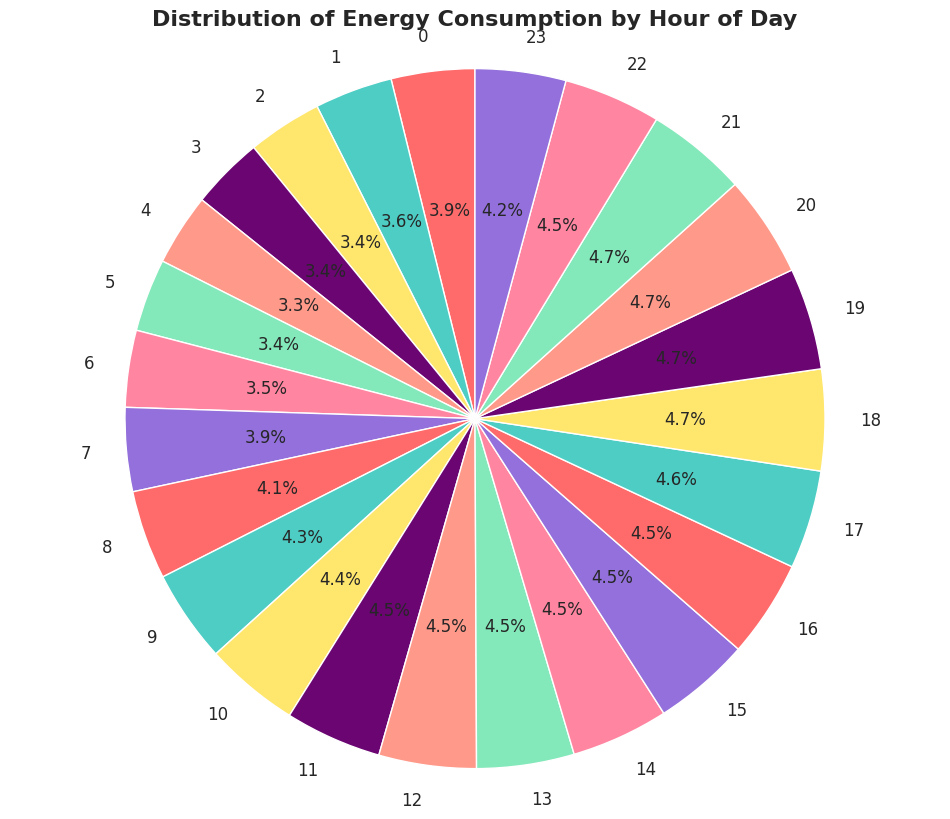

In [ ]:
hourly_avg = df.groupby('hour')['EnergyLoad_MWh'].mean()

plt.figure(figsize=(12, 10))
plt.pie(hourly_avg.values, labels=hourly_avg.index, autopct='%1.1f%%',
        colors=bright_palette, startangle=90)
plt.title('Distribution of Energy Consumption by Hour of Day', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

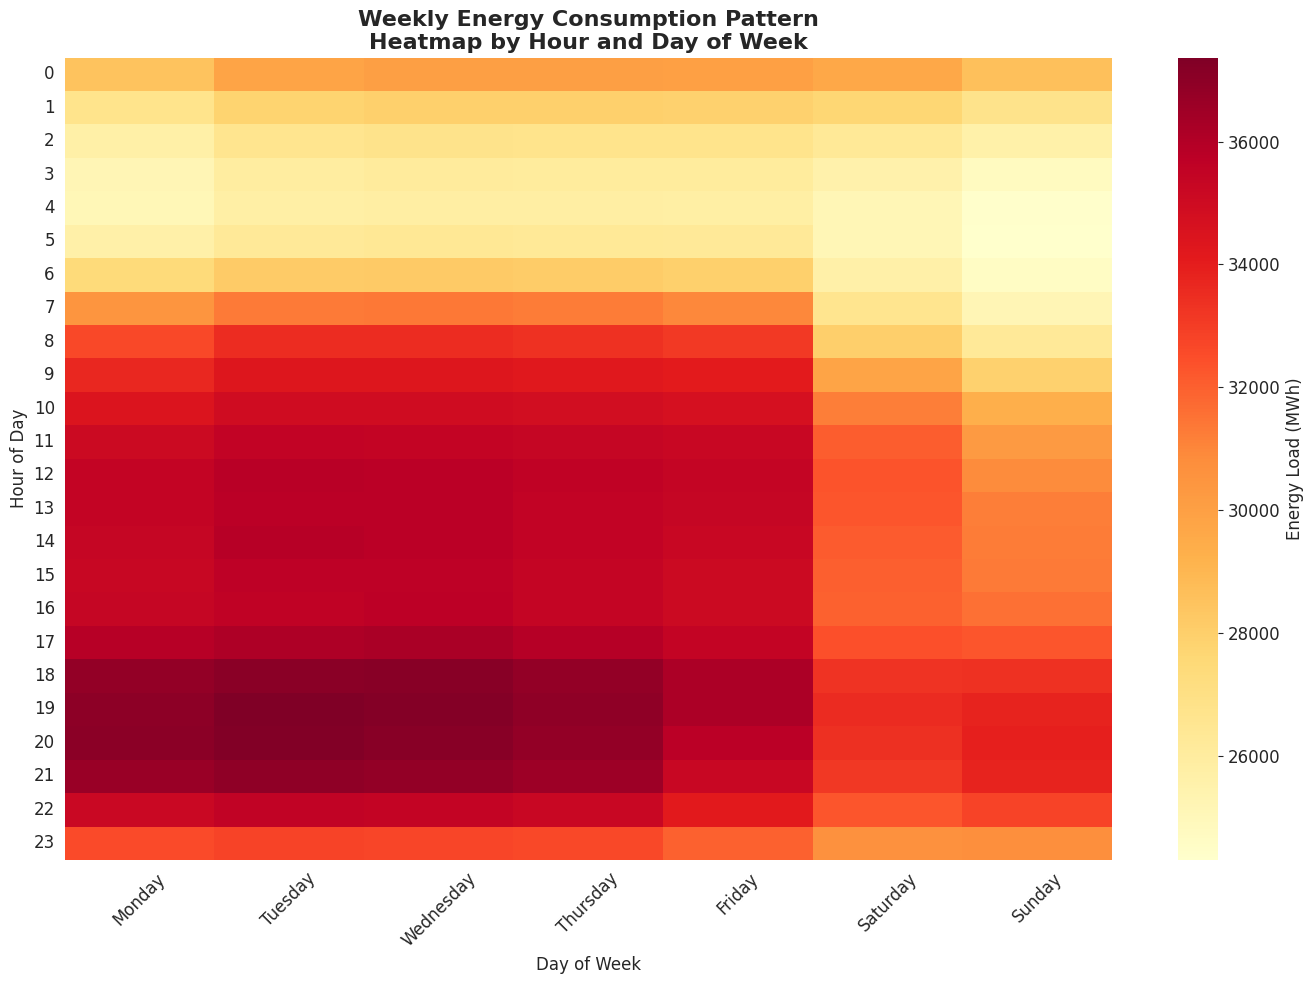

In [ ]:
pivot_table = df.pivot_table(values='EnergyLoad_MWh',
                             index='hour',
                             columns='day_of_week',
                             aggfunc='mean')

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=False, fmt='.0f',
            cbar_kws={'label': 'Energy Load (MWh)'})
plt.title('Weekly Energy Consumption Pattern\nHeatmap by Hour and Day of Week',
          fontsize=16, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.xticks(ticks=np.arange(7)+0.5, labels=days, rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

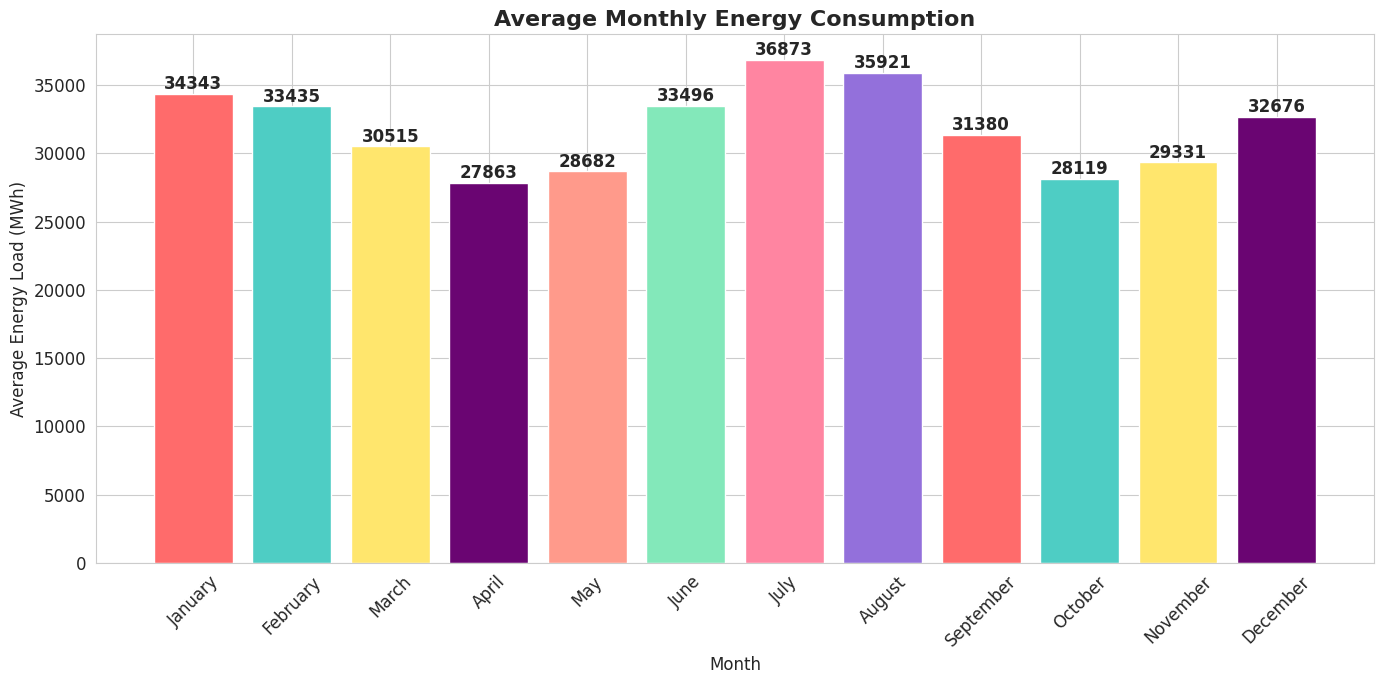

In [ ]:
df['month_name'] = df.index.month_name()

monthly_avg = df.groupby('month_name')['EnergyLoad_MWh'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

plt.figure(figsize=(14, 7))
bars = plt.bar(monthly_avg.index, monthly_avg.values, color=bright_palette*2)
plt.title('Average Monthly Energy Consumption', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Energy Load (MWh)')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


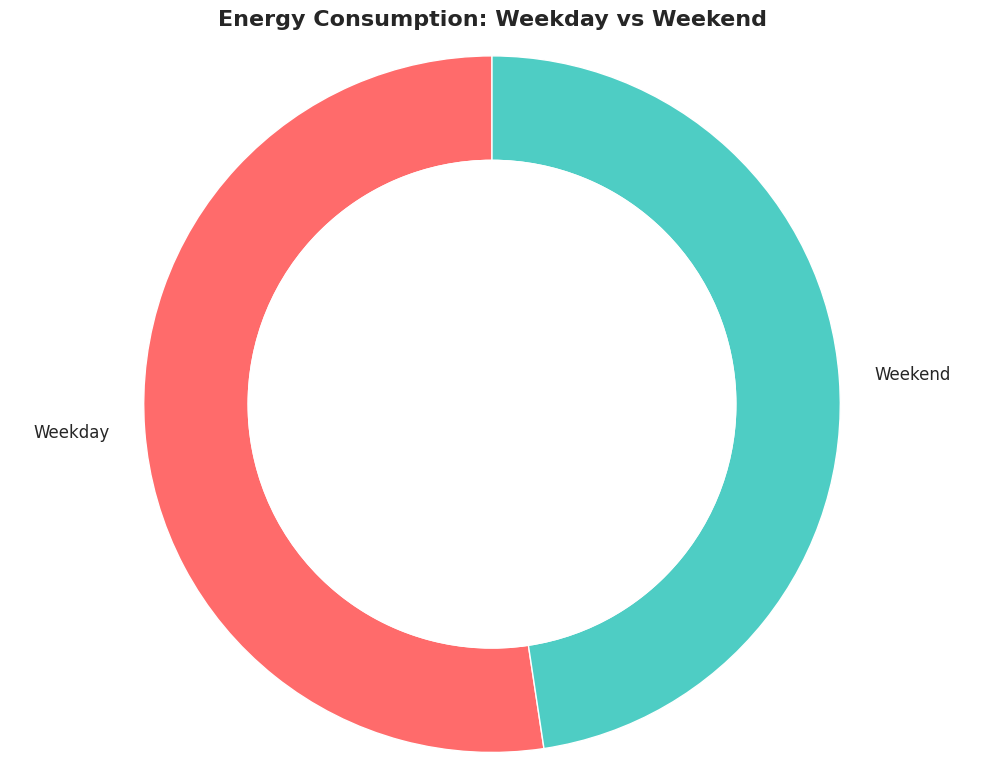

In [ ]:
df['day_type'] = df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
day_type_avg = df.groupby('day_type')['EnergyLoad_MWh'].mean()

plt.figure(figsize=(10, 8))
colors = ['#FF6B6B', '#4ECDC4']
wedges, texts, autotexts = plt.pie(day_type_avg.values, labels=day_type_avg.index,
                                   colors=colors, autopct='%1.1f%%', startangle=90,
                                   wedgeprops=dict(width=0.3))

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Energy Consumption: Weekday vs Weekend', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()


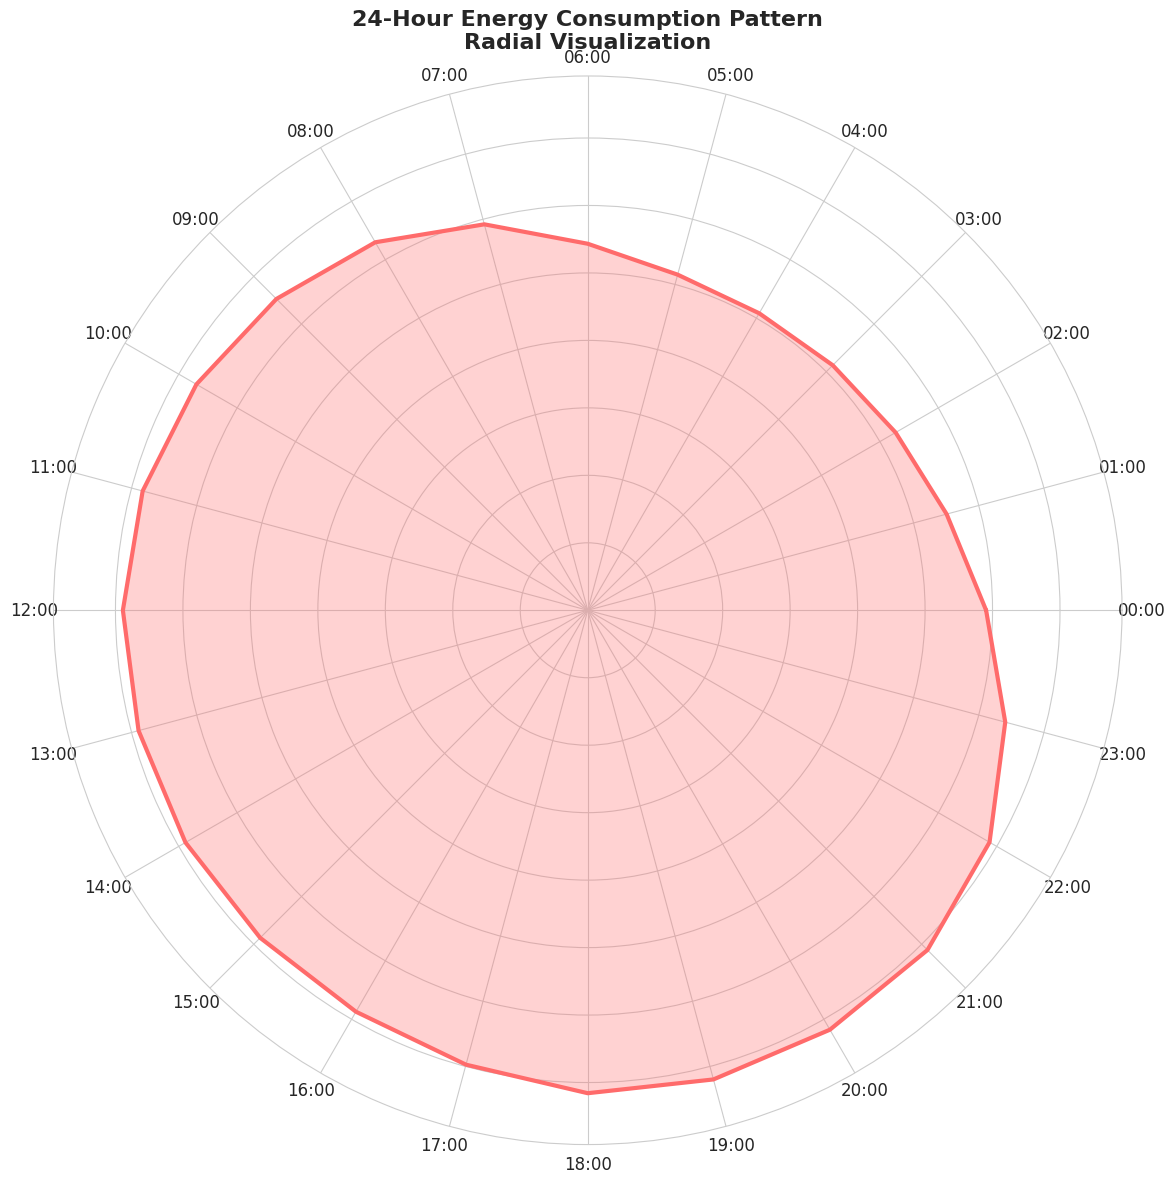

In [ ]:
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False).tolist()
angles += angles[:1]
hourly_avg_radial = hourly_avg.tolist()
hourly_avg_radial += hourly_avg_radial[:1]

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
ax.plot(angles, hourly_avg_radial, color='#FF6B6B', linewidth=3)
ax.fill(angles, hourly_avg_radial, color='#FF6B6B', alpha=0.3)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([f'{h:02d}:00' for h in range(24)])

ax.set_yticklabels([])
ax.set_ylim(0, max(hourly_avg_radial) * 1.1)

plt.title('24-Hour Energy Consumption Pattern\nRadial Visualization',
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


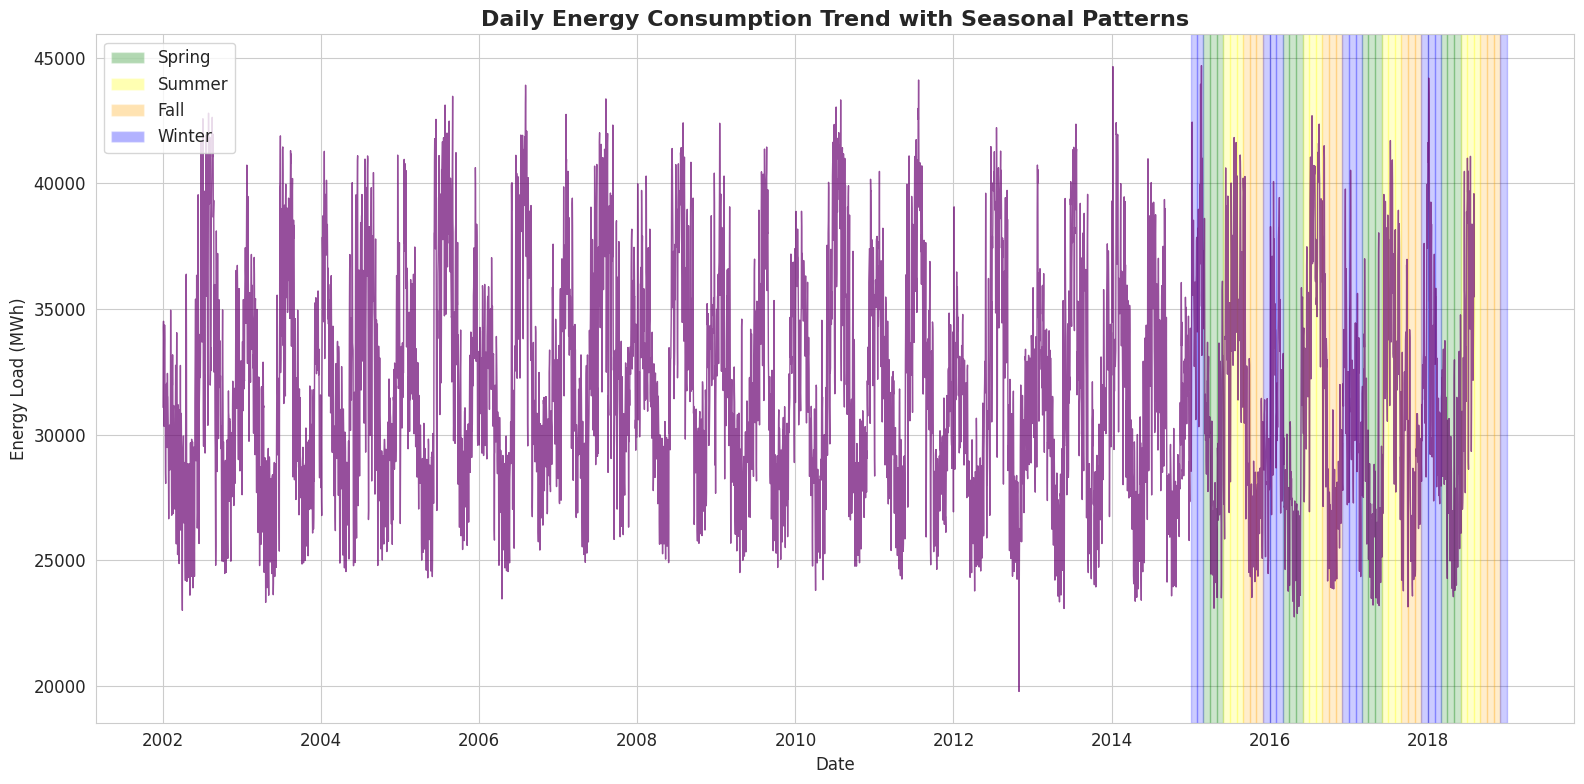

In [ ]:
daily_data = df.resample('D')['EnergyLoad_MWh'].mean()

plt.figure(figsize=(16, 8))
plt.plot(daily_data.index, daily_data.values, alpha=0.7, linewidth=1, color='#6A0572')
plt.title('Daily Energy Consumption Trend with Seasonal Patterns',
          fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Energy Load (MWh)')

spring = [3, 4, 5]
summer = [6, 7, 8]
fall = [9, 10, 11]
winter = [12, 1, 2] y

def highlight_season(months, color, alpha=0.2):
    for year in range(2015, 2019):
        for month in months:
            start_date = f'{year}-{month:02d}-01'
            if month == 12:
                end_date = f'{year+1}-01-01'
            else:
                end_date = f'{year}-{month+1:02d}-01'
            plt.axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date),
                       color=color, alpha=alpha)

highlight_season(spring, 'green')
highlight_season(summer, 'yellow')
highlight_season(fall, 'orange')
highlight_season(winter, 'blue')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.3, label='Spring'),
    Patch(facecolor='yellow', alpha=0.3, label='Summer'),
    Patch(facecolor='orange', alpha=0.3, label='Fall'),
    Patch(facecolor='blue', alpha=0.3, label='Winter')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


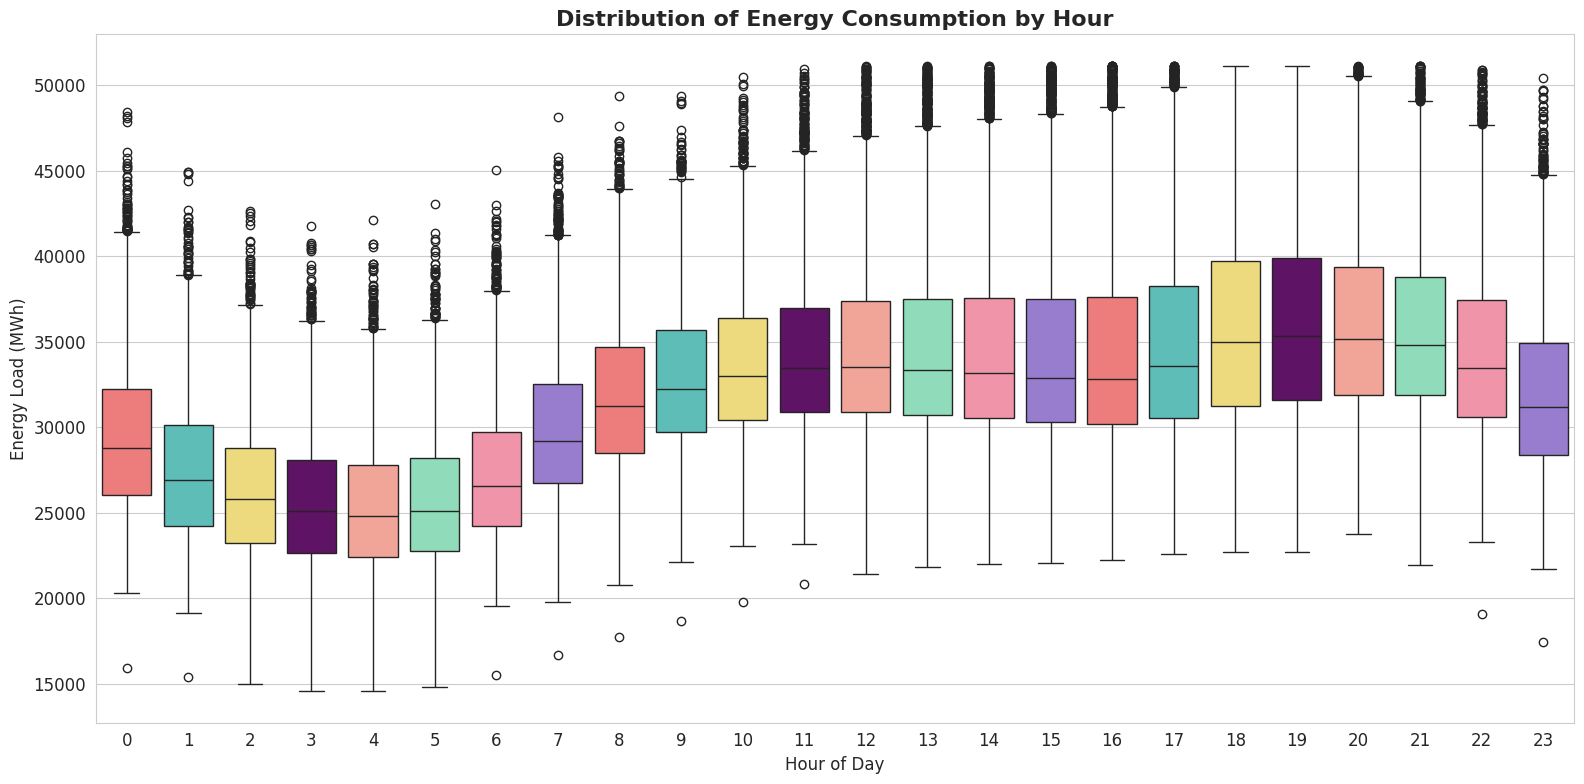

In [ ]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='hour', y='EnergyLoad_MWh', data=df, palette=bright_palette)
plt.title('Distribution of Energy Consumption by Hour', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Load (MWh)')
plt.tight_layout()
plt.show()


In [ ]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    df['lag_24'] = df['EnergyLoad_MWh'].shift(24)
    df['lag_168'] = df['EnergyLoad_MWh'].shift(168)
    return df

df_featured = create_features(df)

df_featured.dropna(inplace=True)

display(df_featured.head())


,EnergyLoad_MWh,hour,day_of_week,month_name,day_type,dayofweek,quarter,month,year,dayofyear,weekofyear,lag_24,lag_168
Datetime,,,,,,,,,,,,,
2002-01-08 01:00:00,29445.0,1,1,January,Weekday,1,1,1,2002,8,2,26862.0,30393.0
2002-01-08 02:00:00,28670.0,2,1,January,Weekday,1,1,1,2002,8,2,25976.0,29265.0
2002-01-08 03:00:00,28375.0,3,1,January,Weekday,1,1,1,2002,8,2,25641.0,28357.0
2002-01-08 04:00:00,28542.0,4,1,January,Weekday,1,1,1,2002,8,2,25666.0,27899.0
2002-01-08 05:00:00,29261.0,5,1,January,Weekday,1,1,1,2002,8,2,26328.0,28057.0


Training data range: 2002-01-08 01:00:00 to 2017-12-31 23:00:00
Testing data range: 2018-01-01 00:00:00 to 2018-08-03 00:00:00


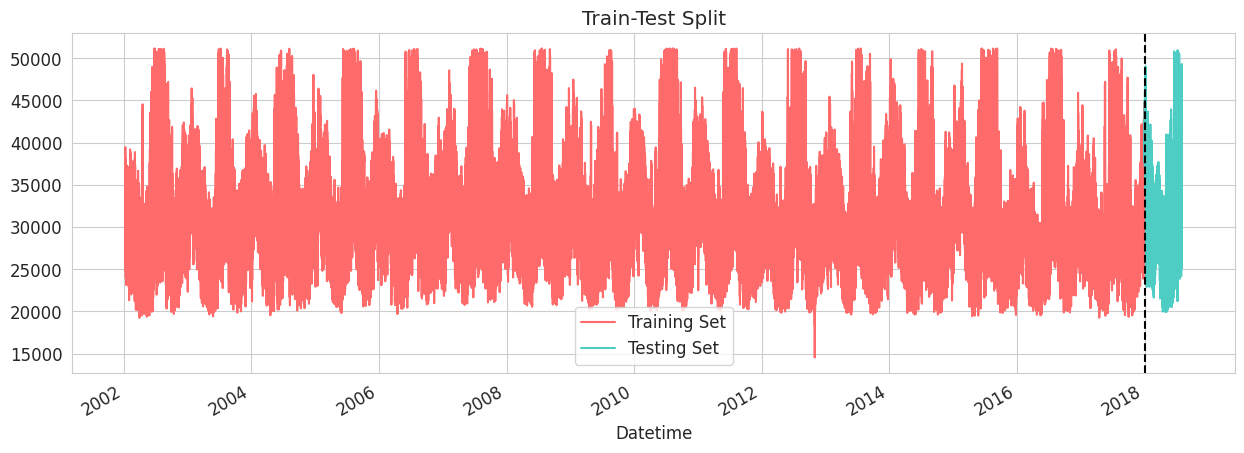

In [ ]:
split_date = '2018-01-01'
train = df_featured.loc[df_featured.index < split_date]
test = df_featured.loc[df_featured.index >= split_date]

print(f"Training data range: {train.index.min()} to {train.index.max()}")
print(f"Testing data range: {test.index.min()} to {test.index.max()}")

fig, ax = plt.subplots(figsize=(15, 5))
train['EnergyLoad_MWh'].plot(ax=ax, label='Training Set')
test['EnergyLoad_MWh'].plot(ax=ax, label='Testing Set')
ax.axvline(pd.to_datetime(split_date), color='black', ls='--')
ax.legend(['Training Set', 'Testing Set'])
plt.title('Train-Test Split')
plt.show()

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'weekofyear', 'lag_24', 'lag_168']
TARGET = 'EnergyLoad_MWh'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(random_state=42, verbose=-1)
}

predictions = {}
model_metrics = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    predictions[name] = pred

    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mape = mean_absolute_percentage_error(y_test, pred)
    model_metrics[name] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.4f}\n")


Training Random Forest...
Random Forest - MAE: 2093.80, RMSE: 2861.77, MAPE: 0.0649

Training Gradient Boosting...
Gradient Boosting - MAE: 2069.84, RMSE: 2838.37, MAPE: 0.0643

Training XGBoost...
XGBoost - MAE: 2118.50, RMSE: 2889.57, MAPE: 0.0654

Training LightGBM...
LightGBM - MAE: 1989.97, RMSE: 2695.05, MAPE: 0.0618



,MAE,RMSE,MAPE
LightGBM,1989.970082,2695.048210,0.061786
Gradient Boosting,2069.840415,2838.367822,0.064307
Random Forest,2093.801423,2861.774214,0.064940
XGBoost,2118.495908,2889.569823,0.065385


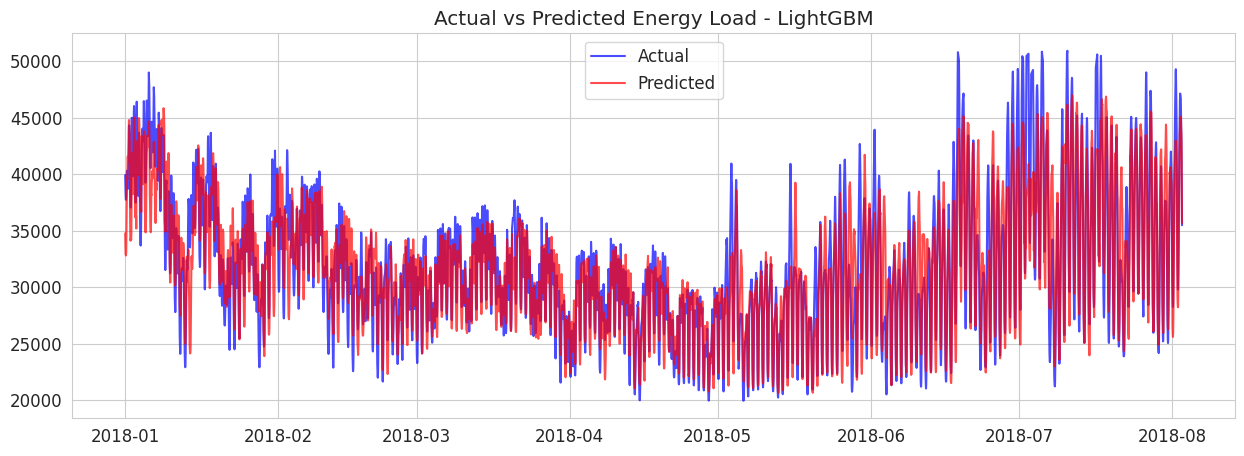

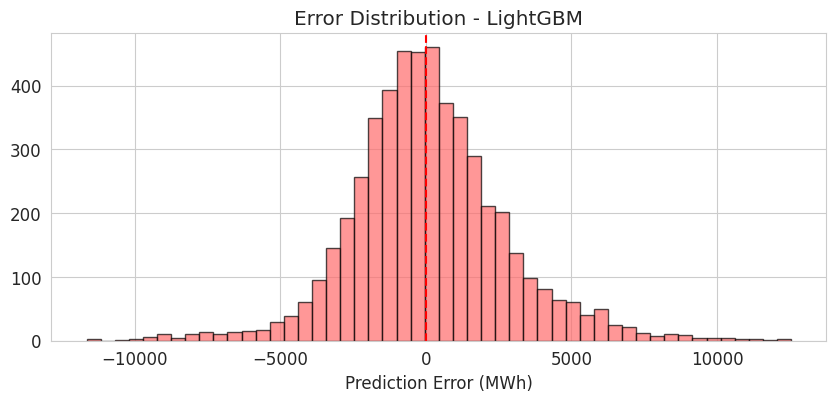

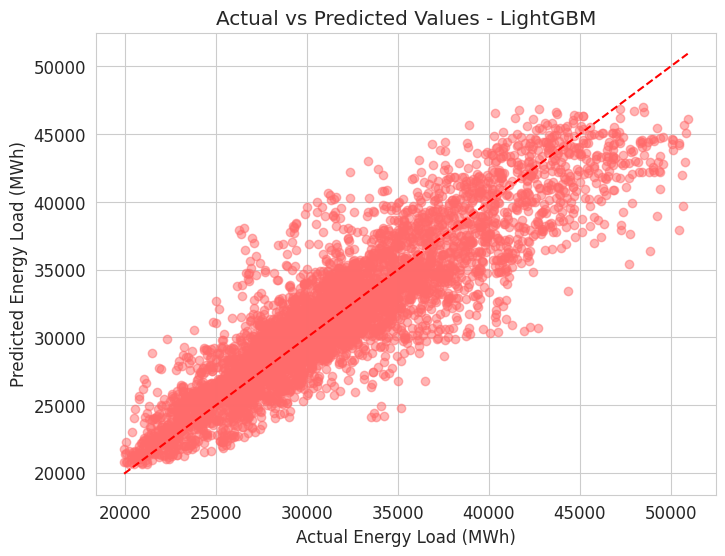

In [ ]:
metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index')
display(metrics_df.sort_values('RMSE'))

best_model_name = metrics_df['RMSE'].idxmin()
best_pred = predictions[best_model_name]

plt.figure(figsize=(15, 5))
plt.plot(test.index, y_test, label='Actual', alpha=0.7, color='blue')
plt.plot(test.index, best_pred, label='Predicted', alpha=0.7, color='red')
plt.title(f'Actual vs Predicted Energy Load - {best_model_name}')
plt.legend()
plt.show()

error = y_test - best_pred
plt.figure(figsize=(10, 4))
plt.hist(error, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (MWh)')
plt.title(f'Error Distribution - {best_model_name}')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, best_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Energy Load (MWh)')
plt.ylabel('Predicted Energy Load (MWh)')
plt.title(f'Actual vs Predicted Values - {best_model_name}')
plt.show()


LSTM Training Shape: (138567, 72, 1), (138567, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4331/4331 ━━━━━━━━━━━━━━━━━━━━ 261s 59ms/step - loss: 0.0127 - val_loss: 0.0021
Epoch 2/10
4331/4331 ━━━━━━━━━━━━━━━━━━━━ 257s 59ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/10
4331/4331 ━━━━━━━━━━━━━━━━━━━━ 254s 59ms/step - loss: 0.0012 - val_loss: 4.4987e-04
Epoch 4/10
4331/4331 ━━━━━━━━━━━━━━━━━━━━ 262s 59ms/step - loss: 9.6501e-04 - val_loss: 7.3796e-04
Epoch 5/10
4331/4331 ━━━━━━━━━━━━━━━━━━━━ 258s 59ms/step - loss: 8.5523e-04 - val_loss: 2.8205e-04
Epoch 6/10
4331/4331 ━━━━━━━━━━━━━━━━━━━━ 262s 60ms/step - loss: 8.0345e-04 - val_loss: 4.2504e-04
Epoch 7/10
4331/4331 ━━━━━━━━━━━━━━━━━━━━ 262s 61ms/step - loss: 7.7578e-04 - val_loss: 2.7767e-04
Epoch 8/10
4331/4331 ━━━━━━━━━━━━━━━━━━━━ 259s 60ms/step - loss: 7.3791e-04 - val_loss: 4.2269e-04
Epoch 9/10
4331/4331 ━━━━━━━━━━━━━━━━━━━━ 264s 60ms/step - loss: 7.2579e-04 - val_loss: 2.5224e-04
Epoch 10/10
4331/4331 ━━━━━━━━━━━━━━━━━━━━ 260s 60ms/step - loss: 7.0727e-04 - val_loss: 2.8119e-04


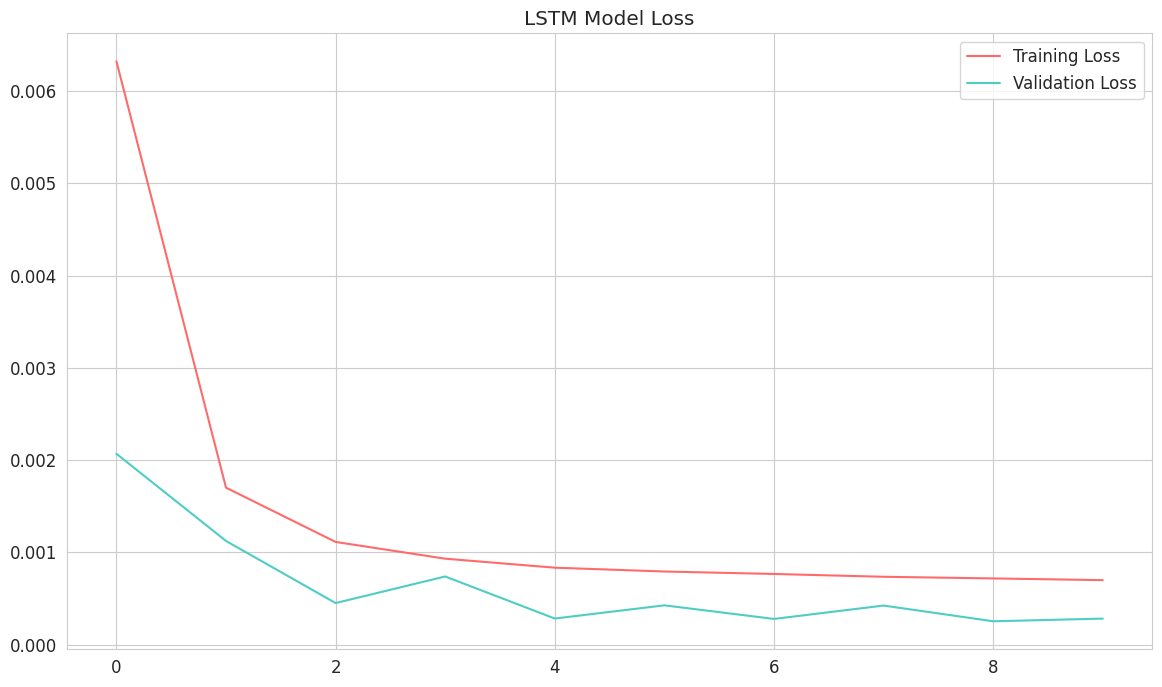

LSTM - MAE: 471.38, RMSE: 613.92, MAPE: 0.0153


In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[[TARGET]])
scaled_test = scaler.transform(test[[TARGET]])

def create_sequences(data, sequence_length=24):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 72
X_train_seq, y_train_seq = create_sequences(scaled_train, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(scaled_test, SEQ_LENGTH)

print(f"LSTM Training Shape: {X_train_seq.shape}, {y_train_seq.shape}")

lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
lstm_model.summary()

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1,
    shuffle=False
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('LSTM Model Loss')
plt.show()

lstm_pred = lstm_model.predict(X_test_seq, verbose=0)
lstm_pred = scaler.inverse_transform(lstm_pred).flatten()

y_test_aligned = test[TARGET].iloc[SEQ_LENGTH:]

lstm_mae = mean_absolute_error(y_test_aligned, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test_aligned, lstm_pred))
lstm_mape = mean_absolute_percentage_error(y_test_aligned, lstm_pred)

print(f"LSTM - MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}, MAPE: {lstm_mape:.4f}")

model_metrics['LSTM'] = {'MAE': lstm_mae, 'RMSE': lstm_rmse, 'MAPE': lstm_mape}


,MAE,RMSE,MAPE
LSTM,471.379130,613.922368,0.015286
LightGBM,1989.970082,2695.048210,0.061786
Gradient Boosting,2069.840415,2838.367822,0.064307
Random Forest,2093.801423,2861.774214,0.064940
XGBoost,2118.495908,2889.569823,0.065385


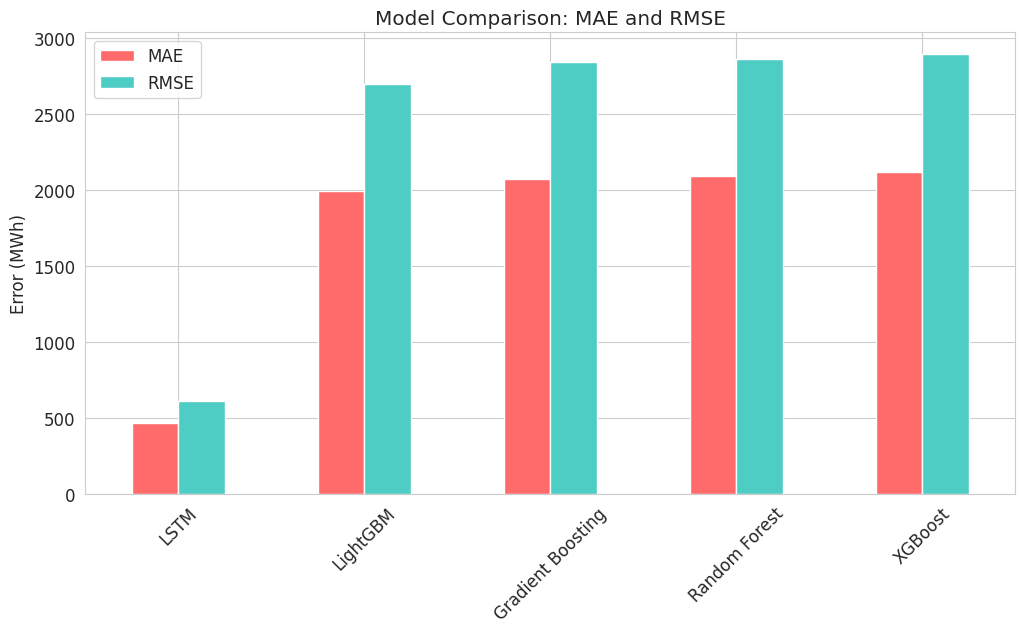

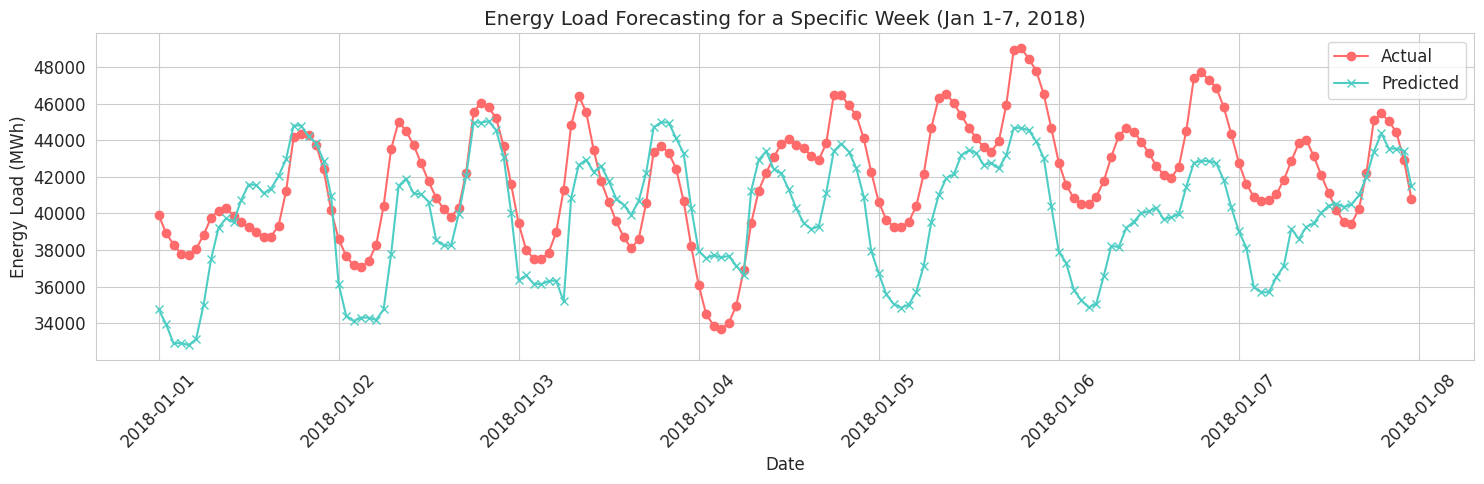

Best Model: LightGBM
MAE: 1989.97
RMSE: 2695.05
MAPE: 0.0618


In [ ]:

final_metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index')
final_metrics_df.sort_values('RMSE', inplace=True)
display(final_metrics_df)

final_metrics_df[['MAE', 'RMSE']].plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison: MAE and RMSE')
plt.ylabel('Error (MWh)')
plt.xticks(rotation=45)
plt.show()

example_week = test.loc['2018-01-01':'2018-01-07']
example_pred = predictions[best_model_name][:len(example_week)]

plt.figure(figsize=(15, 5))
plt.plot(example_week.index, example_week[TARGET], label='Actual', marker='o')
plt.plot(example_week.index, example_pred, label='Predicted', marker='x')
plt.title('Energy Load Forecasting for a Specific Week (Jan 1-7, 2018)')
plt.xlabel('Date')
plt.ylabel('Energy Load (MWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Best Model: {best_model_name}")
print(f"MAE: {final_metrics_df.loc[best_model_name, 'MAE']:.2f}")
print(f"RMSE: {final_metrics_df.loc[best_model_name, 'RMSE']:.2f}")
print(f"MAPE: {final_metrics_df.loc[best_model_name, 'MAPE']:.4f}")
